<a href="https://colab.research.google.com/github/HANW001/tzip/blob/main/open.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!pip install opencv-python==4.5.1.48

In [31]:
print(cv2.__version__)

4.5.1


In [32]:
import cv2
import numpy as np
from data.proto_file_path import *
from data.weights_file_path import *
from data.BODY_PARTS import *
from data.POSE_PAIRS import *
from data.yolo_classes import classes



┌───────────────────────────────────── test.jpg START ─────────────────────────────────────┐
│────────────────────────────────────────── YOLO ──────────────────────────────────────────│
│ [person_1] conf: 0.9265182614326477 / x: 114 / y: 23 / width: 280 / height: 362          │
│───────────────────────────────────────── POINT ──────────────────────────────────────────│
│ [pointed] Nose (0) => prob: 0.88072 / x: 304 / y: 125                                    │
│ [pointed] Neck (1) => prob: 0.69465 / x: 304 / y: 150                                    │
│ [pointed] RShoulder (2) => prob: 0.62675 / x: 255 / y: 158                               │
│ [pointed] RElbow (3) => prob: 0.60349 / x: 182 / y: 116                                  │
│ [pointed] RWrist (4) => prob: 0.65816 / x: 146 / y: 58                                   │
│ [pointed] LShoulder (5) => prob: 0.77199 / x: 340 / y: 141                               │
│ [pointed] LElbow (6) => prob: 0.82814 / x: 377 / y: 91             

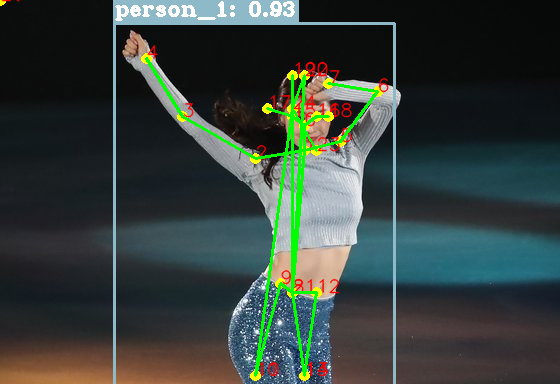

In [38]:


def yolo(size, score_threshold, nms_threshold):
    # YOLO 네트워크 불러오기
    weights = '/content/yolov4.weights'
    cfg = '/content/yolov4.cfg'
    net = cv2.dnn.readNet(weights, cfg)
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    # GPU 사용
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # 클래스의 갯수만큼 랜덤 RGB 배열을 생성
    colors = np.random.uniform(0, 255, size=(len(classes), 3))

    # 이미지의 높이, 너비, 채널 받아오기
    height, width, channels = frame_origin.shape

    # 네트워크에 넣기 위한 전처리
    blob = cv2.dnn.blobFromImage(frame_origin, 0.00392, (size, size), (0, 0, 0), True, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(blob)

    # 결과 받아오기
    outs = net.forward(output_layers)

    # 각각의 데이터를 저장할 리스트 생성 및 초기화
    class_ids = []
    confidences = []
    boxes = []
    nms_boxes.clear()

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.1:
                # 탐지된 객체의 너비, 높이 및 중앙 좌표값 찾기
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # 객체의 사각형 테두리 중 좌상단 좌표값 찾기
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    print('│' + " YOLO ".center(90, '─') + '│')
    # 후보 박스(x, y, width, height) 출력
    # print(f"│boxes: {boxes}")
    # print(f"│confidences: {confidences}")

    # 노이즈 제거 (Non Maximum Suppression) (겹쳐있는 박스 중 상자가 물체일 확률이 가장 높은 박스만 남겨둠)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=score_threshold, nms_threshold=nms_threshold)

    # NMS 을 통해 걸러진 박스의 인덱스 출력
    # print(f"│indexes: ", end='')
    # for index in indexes:
    #     print(index, end=' ')
    # print()

    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            class_name = classes[class_ids[i]]

            # 중복된 객체를 이름 뒤 숫자를 추가하여 구분
            class_name += '_1'
            num = 1
            while class_name in nms_boxes.keys():
                num += 1
                class_name = class_name[:-1] + str(num)

            # 프레임에 작성할 텍스트 및 색깔 지정
            label = f"{class_name}: {confidences[i]:.2f}"
            color = colors[class_ids[i]]

            # 프레임에 사각형 테두리 그리기 및 텍스트 쓰기
            cv2.rectangle(frame_drawn, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(frame_drawn, (x - 1, y), (x + len(class_name) * 13 + 80, y - 25), color, -1)
            cv2.putText(frame_drawn, label, (x, y - 8), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255), 2)

            # 탐지된 객체의 정보 출력 및 nms_boxex 에 저장
            print('{0}│'.format(
                f"│ [{class_name}] conf: {confidences[i]} / x: {x} / y: {y} / width: {w} / height: {h}".ljust(91, ' ')))
            nms_boxes[class_name] = [x, y, w, h]


def output_keypoints(proto_file, weights_file, threshold, BODY_PARTS):
    global points

    # 네트워크 불러오기
    net = cv2.dnn.readNetFromCaffe(proto_file, weights_file)

    # GPU 사용
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

    # 입력 이미지의 사이즈 정의
    image_height = 368
    image_width = 368

    # 네트워크에 넣기 위한 전처리
    input_blob = cv2.dnn.blobFromImage(frame_origin, 1.0 / 255, (image_width, image_height), (0, 0, 0),
                                       swapRB=False, crop=False)

    # 전처리된 blob 네트워크에 입력
    net.setInput(input_blob)

    # 결과 받아오기
    out = net.forward()
    # The output is a 4D matrix :
    # The first dimension being the image ID ( in case you pass more than one image to the network ).
    # The second dimension indicates the index of a keypoint.
    # The model produces Confidence Maps and Part Affinity maps which are all concatenated.
    # For COCO model it consists of 57 parts – 18 keypoint confidence Maps + 1 background + 19*2 Part Affinity Maps. Similarly, for MPI, it produces 44 points.
    # We will be using only the first few points which correspond to Keypoints.
    # The third dimension is the height of the output map.
    out_height = out.shape[2]
    # The fourth dimension is the width of the output map.
    out_width = out.shape[3]

    # 원본 이미지의 높이, 너비를 받아오기
    frame_height, frame_width = frame_origin.shape[:2]

    # 포인트 리스트 초기화
    points = []

    print('│' + " POINT ".center(90, '─') + '│')
    for i in range(len(BODY_PARTS)):

        # 신체 부위의 confidence map
        prob_map = out[0, i, :, :]

        # 최소값, 최대값, 최소값 위치, 최대값 위치
        min_val, prob, min_loc, point = cv2.minMaxLoc(prob_map)

        # 원본 이미지에 맞게 포인트 위치 조정
        x = int((frame_width * point[0]) / out_width)
        y = int((frame_height * point[1]) / out_height)

        if prob > threshold:  # [pointed]
            cv2.circle(frame_drawn, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_drawn, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 1,
                        lineType=cv2.LINE_AA)

            points.append((x, y))
            print('{0}│'.format(
                f"│ [pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}".ljust(91, ' ')))

        else:  # [not pointed]
            cv2.circle(frame_drawn, (x, y), 5, (0, 255, 255), thickness=-1, lineType=cv2.FILLED)
            cv2.putText(frame_drawn, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 1,
                        lineType=cv2.LINE_AA)

            points.append(None)
            print('{0}│'.format(
                f"│ [not pointed] {BODY_PARTS[i]} ({i}) => prob: {prob:.5f} / x: {x} / y: {y}".ljust(91, ' ')))


def output_keypoints_with_lines(POSE_PAIRS):
    print('│' + " LINK ".center(90, '─') + '│')
    for pair in POSE_PAIRS:
        part_a = pair[0]  # 0 (Head)
        part_b = pair[1]  # 1 (Neck)
        if points[part_a] and points[part_b]:
            print('{0}│'.format(f"│ [linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}".ljust(91, ' ')))
            cv2.line(frame_drawn, points[part_a], points[part_b], (0, 255, 0), 2)
        else:
            print(
                '{0}│'.format(f"│ [not linked] {part_a} {points[part_a]} <=> {part_b} {points[part_b]}".ljust(91, ' ')))

def in_box():
    print('│' + " IN BOX ".center(90, '─') + '│')
    for key, value in nms_boxes.items():
        if key.split('_')[0] != "person":  # person 오브젝트 제외
            points_string = ""
            for index, point in enumerate(points):
                if point is not None and index != 25:  # point 가 없을 경우와 배경일 경우 제외
                    x = value[0]
                    y = value[1]
                    width = value[0] + value[2]
                    height = value[1] + value[3]
                    if (point[0] > x) and (point[0] < width) and (point[1] > y) and (point[1] < height):
                        points_string += str(index) + ' '
            if len(points_string) > 0:
                print('│{0}│'.format((f" [{key}] " + points_string).ljust(90, ' ')))

# 이미지 경로
test = "/content/test.jpg" 
images = [test]

# 키포인트를 저장할 리스트 생성
points = []

# NMS 를 거친 객체 box 들의 정보를 저장할 딕셔너리 생성 (in_box() 함수에서 사용됨)
nms_boxes = {}

# 입력 사이즈 리스트 (Yolo 에서 사용되는 네크워크 입력 이미지 사이즈)
size_list = [320, 416, 608]

for image in images:
    file_name = image.split('/')[-1]
    text_start = ' ' + file_name + " START "
    text_end = ' ' + file_name + " END"

    print('\n┌' + text_start.center(90, '─') + '┐')
    # 이미지 읽어오기
    frame_origin = cv2.imread(image)  # 네트워크에 넣을 프레임
    frame_drawn = cv2.imread(image)  # 텍스트 및 테두리가 그려질 프레임

    yolo(size=size_list[1], score_threshold=0.4, nms_threshold=0.4)
    output_keypoints(proto_file='/content/body_25/pose_deploy.prototxt', weights_file='/content/pose_iter_584000.caffemodel', threshold=0, BODY_PARTS=BODY_PARTS_BODY_25)
    output_keypoints_with_lines(POSE_PAIRS=POSE_PAIRS_BODY_25)
    in_box()
    print('└' + text_end.center(90, '─') + '┘')
  
    cv2_imshow(frame_drawn)
    if cv2.waitKey(0) == 27:  # esc 입력시 종료
        break
    cv2.destroyAllWindows()

In [ ]:
pwd
